In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 128
EPOCHS = 60
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(BASIC_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [6]:
train_trials = read_dataset("data/train_passive_trials.h5", n_trials=3000)
val_trials = read_dataset("data/val_passive_trials.h5")

100%|██████████| 500/500 [00:02<00:00, 236.68it/s]


# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [7]:
loaders, scaler = prepare_dataset([train_trials, val_trials], class_columns=MASS_CLASS_COLS, 
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

100%|██████████| 500/500 [00:00<00:00, 1117.06it/s]


In [8]:
train_loader, val_loader = loaders

In [9]:
class_proportions(train_loader)
class_proportions(val_loader)

[1013  955 1032]
Majority class:  0.344
[218 167 115]
Majority class:  0.436


## Define model, loss and optimizer

In [10]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [11]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS,
                                                           seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.56)	 Train_acc (70.10)	 Val_acc (65.20): 100%|██████████| 60/60 [08:49<00:00,  8.70s/it]


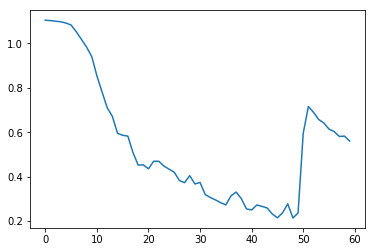

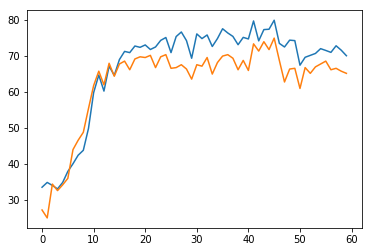

In [12]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [13]:
max(epoch_accuracies[1])

75.0

## Save model and scaler

In [14]:
torch.save(best_model.state_dict(), "models/passive_mass_model.pt")
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

100%|██████████| 196/196 [00:00<00:00, 959.25it/s]


Model's accuracy on test set: 59.183673469387756


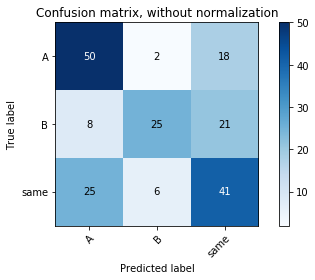

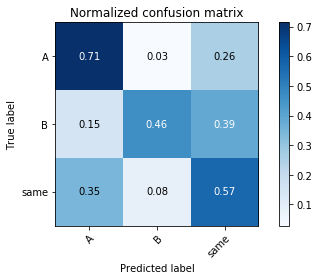

In [15]:
model_path = "models/passive_mass_model.pt"
scaler_path = "scalers/passive_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/passive_trials_exp1.h5"
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [16]:
loaders, scaler = prepare_dataset([train_trials, val_trials], class_columns=FORCE_CLASS_COLS, 
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

100%|██████████| 500/500 [00:00<00:00, 1043.82it/s]


In [17]:
train_loader, val_loader = loaders

In [18]:
class_proportions(train_loader)
print()
class_proportions(val_loader)

[1044  992  964]
Majority class:  0.348

[161 175 164]
Majority class:  0.35


## Define model, loss and optimizer

In [19]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [20]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.10)	 Train_acc (92.00)	 Val_acc (86.60): 100%|██████████| 60/60 [08:46<00:00,  8.76s/it]


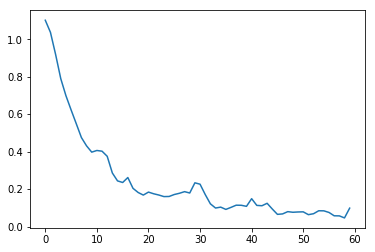

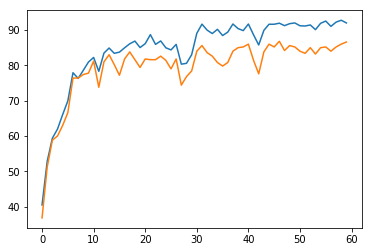

In [21]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [22]:
max(epoch_accuracies[1])

86.8

## Save model and scaler

In [23]:
torch.save(best_model.state_dict(), "models/passive_force_model.pt")
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Evaluate saved model

100%|██████████| 500/500 [00:00<00:00, 1009.53it/s]


Model's accuracy on test set: 84.0


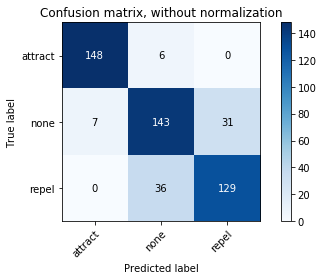

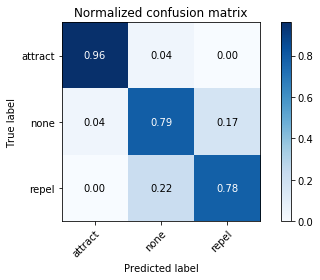

In [24]:
model_path = "models/passive_force_model.pt"
scaler_path = "scalers/passive_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path)